In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats.mstats import winsorize

In [2]:
train = pd.read_csv(".../lending_train.csv")
test = pd.read_csv(".../lending_topredict.csv")


final_id = test['ID'] # For final prediction

## Identify imbalanced dataset

<class 'pandas.core.frame.DataFrame'>
Class 0: 200130
Class 1: 799870
Proportion: 0.25 : 1


<AxesSubplot:title={'center':'Count (loan_paid)'}>

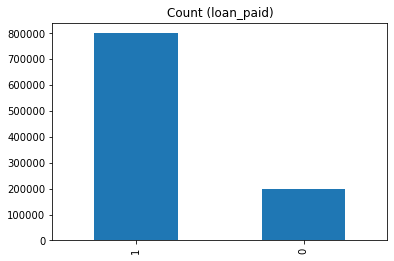

In [3]:
print(type(train))

target_count = train.loan_paid.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (loan_paid)')

## Original test set

In [4]:
new_train = train.sample(frac=1, random_state=42)
print(new_train.shape)

(1000000, 25)


## Undersampling (Create Subsample)

In [115]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples
train = train.sample(frac=1)

# amount of 0 classes 200130 rows.
non_paid_loan = train.loc[train['loan_paid'] == 0]
paid_loan = train.loc[train['loan_paid'] == 1][:200130]

normal_distributed_df = pd.concat([paid_loan, non_paid_loan])

# Shuffle dataframe rows
new_train = normal_distributed_df.sample(frac=1, random_state=42)

new_train.head()

,ID,requested_amnt,loan_duration,employment,employment_length,race,reason_for_loan,extended_reason,annual_income,debt_to_income_ratio,...,delinquency_last_2yrs,fico_score_range_low,fico_score_range_high,fico_inquired_last_6mths,months_since_last_delinq,revolving_balance,total_revolving_limit,type_of_application,any_tax_liens,loan_paid
408628,408628,18350.0,60 months,Operations Manager,1 year,W,debt_consolidation,Debt consolidation,54600.0,23.96,...,0.0,670.0,674.0,1.0,NaN,14649.0,26850.0,Individual,0.0,1
92490,92490,3100.0,36 months,NaN,NaN,B,debt_consolidation,Debt consolidation,10176.0,30.90,...,0.0,650.0,654.0,0.0,NaN,2994.0,9200.0,Individual,0.0,0
856877,856877,24000.0,60 months,Vice President,10+ years,W,debt_consolidation,Debt consolidation,132000.0,10.15,...,1.0,660.0,664.0,0.0,14.0,24286.0,26100.0,Individual,0.0,0
300583,300583,21000.0,36 months,Senior Software Engineer,1 year,W,credit_card,Credit card refinancing,145000.0,2.44,...,1.0,660.0,664.0,1.0,16.0,14345.0,25200.0,Individual,0.0,1
327266,327266,1800.0,36 months,pork lift operator/warehouse,5 years,W,debt_consolidation,Debt consolidation,30000.0,20.24,...,0.0,670.0,674.0,0.0,77.0,8891.0,17100.0,Individual,0.0,0


In [205]:
print(new_train)

            ID  requested_amnt loan_duration                    employment  \
408628  408628         18350.0     60 months            Operations Manager   
92490    92490          3100.0     36 months                           NaN   
856877  856877         24000.0     60 months               Vice President    
300583  300583         21000.0     36 months      Senior Software Engineer   
327266  327266          1800.0     36 months  pork lift operator/warehouse   
...        ...             ...           ...                           ...   
206862  206862         31300.0     60 months                    Superviser   
420341  420341         35000.0     60 months           Senior Art Director   
478545  478545          2500.0     36 months                Loan processor   
605060  605060          6500.0     36 months      Manager, Sustainability    
944511  944511         18900.0     36 months      Administrative Assistant   

       employment_length race     reason_for_loan          exte

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: loan_paid, dtype: float64


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


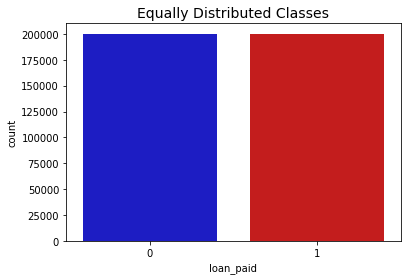

In [116]:
colors = ["#0101DF", "#DF0101"]

print('Distribution of the Classes in the subsample dataset')
print(new_train['loan_paid'].value_counts()/len(new_train))

sns.countplot('loan_paid', data=new_train, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Data Cleaning: Handle missing values and outliers

In [5]:
def separator(data):
    
    #Seperate the columns based on the type (object or numeric)
    loan_object = [] #object type
    loan_numeric = [] #numeric type

    for col_name in data.columns:
        if data [col_name].dtype == 'object':
            loan_object.append(col_name)
        
        if data [col_name].dtype == 'int64' or data [col_name].dtype == 'float64':
            loan_numeric.append(col_name)
    
    return data [loan_object], data [loan_numeric]


train_object_cols, train_num_cols = separator(new_train)
test_object_cols, test_num_cols = separator(test)
    
print(train_object_cols.shape)
print(train_object_cols.dtypes)
print('-'*10, '\n')
print(test_object_cols.shape)
print(test_object_cols.dtypes)

(1000000, 11)
loan_duration            object
employment               object
employment_length        object
race                     object
reason_for_loan          object
extended_reason          object
employment_verified      object
zipcode                  object
state                    object
home_ownership_status    object
type_of_application      object
dtype: object
---------- 

(345310, 12)
loan_duration            object
employment               object
employment_length        object
race                     object
reason_for_loan          object
extended_reason          object
employment_verified      object
zipcode                  object
state                    object
home_ownership_status    object
type_of_application      object
loan_paid                object
dtype: object


In [6]:
train_object_cols_v2 = train_object_cols.drop(['zipcode', 'race', 'state'], axis=1)
test_object_cols_v2 = test_object_cols.drop(['zipcode', 'race', 'state', 'loan_paid'], axis=1)

I decided to drop the <mark>zipcode</mark>, <mark>state</mark> and <mark>race</mark> column for the following reasons:

* Lack of generalizability: Zipcode and state is a highly specific geographic identifier that may not have a direct correlation with the target variable. Including zipcode as a feature in the model might lead to overfitting, where the model learns patterns specific to certain locations instead of capturing more generalizable relationships

* Potential bias and discrimination: Including race as a feature in a machine learning model can introduce biases and lead to discriminatory outcomes. Race is a protected characteristic, and using it as a feature can perpetuate or exacerbate existing social biases, reinforcing disparities or unfair treatment.

Also dropping loan_paid in _object_cols.

## Categorical Columns

In [7]:
print(train_object_cols_v2.isna().sum())
print('-'*10, '\n')
print(test_object_cols_v2.isna().sum())

loan_duration                0
employment               63562
employment_length        58152
reason_for_loan              0
extended_reason          12425
employment_verified          0
home_ownership_status        0
type_of_application          0
dtype: int64
---------- 

loan_duration                0
employment               22223
employment_length        20359
reason_for_loan              0
extended_reason           4234
employment_verified          0
home_ownership_status        0
type_of_application          0
dtype: int64


In [8]:
'''
In this section, we aim to fill missing values in the 'employment' column of the dataset based on a specific condition.
The condition is as follows:

1. The 'employment' column has a NaN (null) value.
2. The 'employment_length' column has a non-null value.

Rows meeting this condition are indicative of individuals having an employment length but with an undefined employment status.
Therefore, we fill these rows with the value 'job' to denote that the individual is employed.
'''

condition = train_object_cols_v2['employment'].isnull() & train_object_cols_v2['employment_length'].notnull()
train_object_cols_v2.loc[condition, 'employment'] = 'job'

condition = test_object_cols_v2['employment'].isnull() & test_object_cols_v2['employment_length'].notnull()
test_object_cols_v2.loc[condition, 'employment'] = 'job'

In [9]:
print(train_object_cols_v2.isna().sum())
print('-'*10, '\n')
print(test_object_cols_v2.isna().sum())

loan_duration                0
employment               57730
employment_length        58152
reason_for_loan              0
extended_reason          12425
employment_verified          0
home_ownership_status        0
type_of_application          0
dtype: int64
---------- 

loan_duration                0
employment               20196
employment_length        20359
reason_for_loan              0
extended_reason           4234
employment_verified          0
home_ownership_status        0
type_of_application          0
dtype: int64


In [10]:
# Creating a new 'employment_status' column
test_object_cols_v2['employment_status'] = np.where(test_object_cols_v2['employment'].notnull(), 1, 0)
train_object_cols_v2['employment_status'] = np.where(train_object_cols_v2['employment'].notnull(), 1, 0)

'''
Explanation:
In this section, we create a new column called 'employment_status' based on the conditions specified.
The conditions are as follows:

1. If the 'employment' column has a non-null value, we assign 1 to the 'employment_status' column.
2. If the 'employment' column has a null value, we assign 0 to the 'employment_status' column.

This allows us to have a binary representation indicating whether an individual has an employment status or not.
'''
train_object_cols_v3 = train_object_cols_v2.drop(['employment'], axis=1)
test_object_cols_v3 = test_object_cols_v2.drop(['employment'], axis=1)


'''
I drop the 'employment' column due to the presence of a large number of unique values, which has the potential to cause overfitting during model training. 
Instead, I introduce a new column called 'employment_status' as a replacement. 
The 'employment_status' column serves to indicate whether an individual is employed or not, with a value of 1 representing employment and 0 indicating otherwise.
'''

train_object_cols_v3.head()

,loan_duration,employment_length,reason_for_loan,extended_reason,employment_verified,home_ownership_status,type_of_application,employment_status
987231,36 months,< 1 year,debt_consolidation,Debt consolidation,Source Verified,MORTGAGE,Individual,1
79954,60 months,10+ years,debt_consolidation,Debt Consolidation Loan,Verified,MORTGAGE,Individual,1
567130,36 months,5 years,credit_card,Credit card refinancing,Source Verified,RENT,Individual,1
500891,36 months,10+ years,credit_card,Credit card refinancing,Verified,MORTGAGE,Individual,1
55399,36 months,10+ years,debt_consolidation,Debt consolidation,Verified,OWN,Individual,1


In [11]:
# Creating a new 'employment_status' column
train_object_cols_v3['extended'] = np.where(train_object_cols_v3['extended_reason'].notnull(), 1, 0)
test_object_cols_v3['extended'] = np.where(test_object_cols_v3['extended_reason'].notnull(), 1, 0)

'''
Explanation:
In this code snippet, we create a new column called 'extended' based on the conditions specified.
The conditions are as follows:

1. If the 'extended_reason' column has a non-null value, we assign 1 to the 'extended' column.
2. If the 'extended_reason' column has a null value, we assign 0 to the 'extended' column.

This allows us to have a binary representation indicating whether an individual has extended the loan

Drop the 'extended_reason' column due to large number of unique values.
'''

train_object_cols_v4 = train_object_cols_v3.drop(['extended_reason'], axis=1)
test_object_cols_v4 = test_object_cols_v3.drop(['extended_reason'], axis=1)

In [12]:
train_object_cols_v4['employment_length'].fillna(train_object_cols_v4['employment_length'].mode()[0], inplace=True)
test_object_cols_v4['employment_length'].fillna(test_object_cols_v4['employment_length'].mode()[0], inplace=True)

'''
Filling NaN values with the mode for categorical columns is a common approach

The mode represents the most frequent value in a categorical column. 
By filling NaN values with the mode, we preserve the distribution and the relative frequencies of the different categories in the column. 
This helps to maintain the overall balance and representation of each category in the dataset.

'''

print(train_object_cols_v4.isna().sum())
print('-'*10, '\n')
print(test_object_cols_v4.isna().sum())

loan_duration            0
employment_length        0
reason_for_loan          0
employment_verified      0
home_ownership_status    0
type_of_application      0
employment_status        0
extended                 0
dtype: int64
---------- 

loan_duration            0
employment_length        0
reason_for_loan          0
employment_verified      0
home_ownership_status    0
type_of_application      0
employment_status        0
extended                 0
dtype: int64


In [13]:
print(train_object_cols_v4.nunique(axis=0))
print('-'*10, '\n')
print(test_object_cols_v4.nunique(axis=0))

loan_duration             2
employment_length        11
reason_for_loan          14
employment_verified       3
home_ownership_status     6
type_of_application       2
employment_status         2
extended                  2
dtype: int64
---------- 

loan_duration             2
employment_length        11
reason_for_loan          14
employment_verified       3
home_ownership_status     6
type_of_application       2
employment_status         2
extended                  2
dtype: int64


## Numerical Columns

In [14]:
train_num_cols_v2 = train_num_cols.drop(['ID'], axis=1) #We don't need it
test_num_cols_v2 = test_num_cols.drop(['ID'], axis=1)

print(train_num_cols_v2.isna().sum())
print('-'*10, '\n')
print(test_num_cols_v2.isna().sum())

requested_amnt                   0
annual_income                    0
debt_to_income_ratio           278
public_bankruptcies            516
delinquency_last_2yrs            0
fico_score_range_low             0
fico_score_range_high            0
fico_inquired_last_6mths         1
months_since_last_delinq    504309
revolving_balance                0
total_revolving_limit        50231
any_tax_liens                   28
loan_paid                        0
dtype: int64
---------- 

requested_amnt                   0
annual_income                    0
debt_to_income_ratio            96
public_bankruptcies            181
delinquency_last_2yrs            0
fico_score_range_low             0
fico_score_range_high            0
fico_inquired_last_6mths         0
months_since_last_delinq    174434
revolving_balance                0
total_revolving_limit        17296
any_tax_liens                   11
dtype: int64


## Distribution for train set

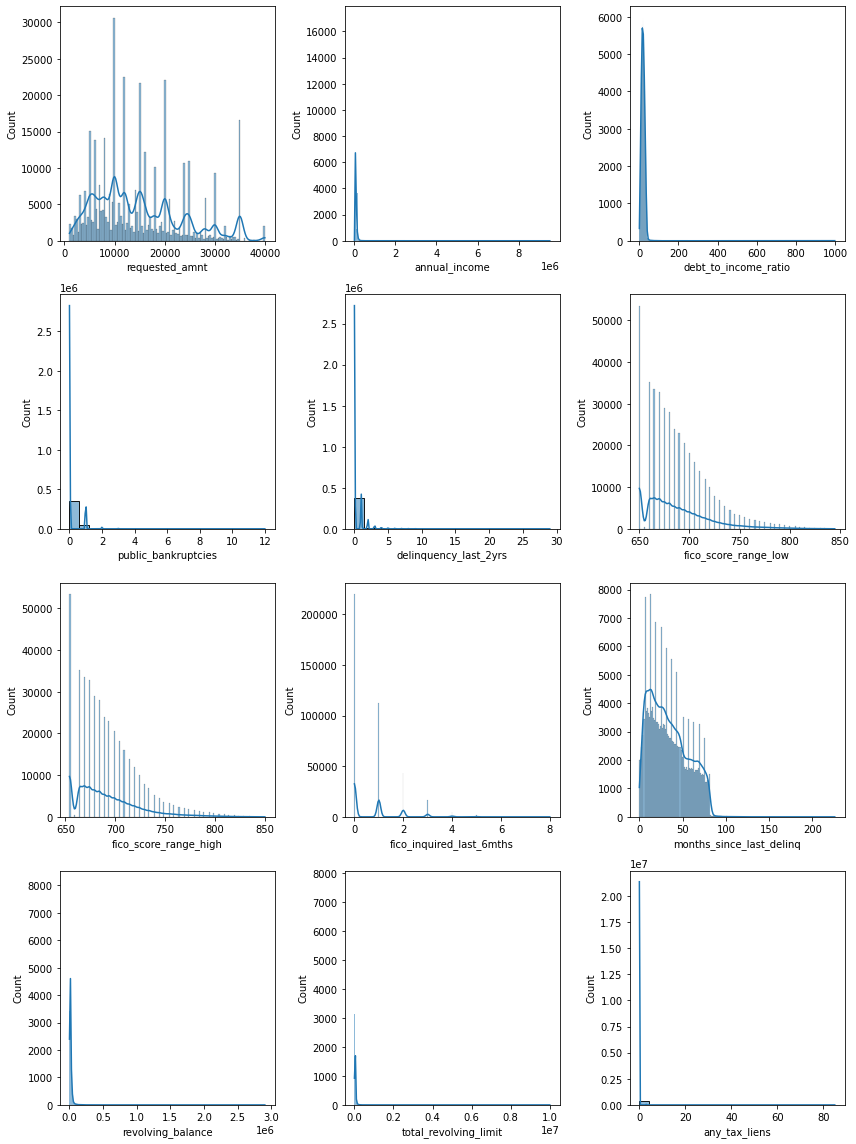

In [17]:
# Define the columns
columns = ['requested_amnt', 'annual_income', 'debt_to_income_ratio', 'public_bankruptcies',
           'delinquency_last_2yrs', 'fico_score_range_low', 'fico_score_range_high',
           'fico_inquired_last_6mths', 'months_since_last_delinq', 'revolving_balance',
           'total_revolving_limit', 'any_tax_liens']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(train_num_cols_v2[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()     

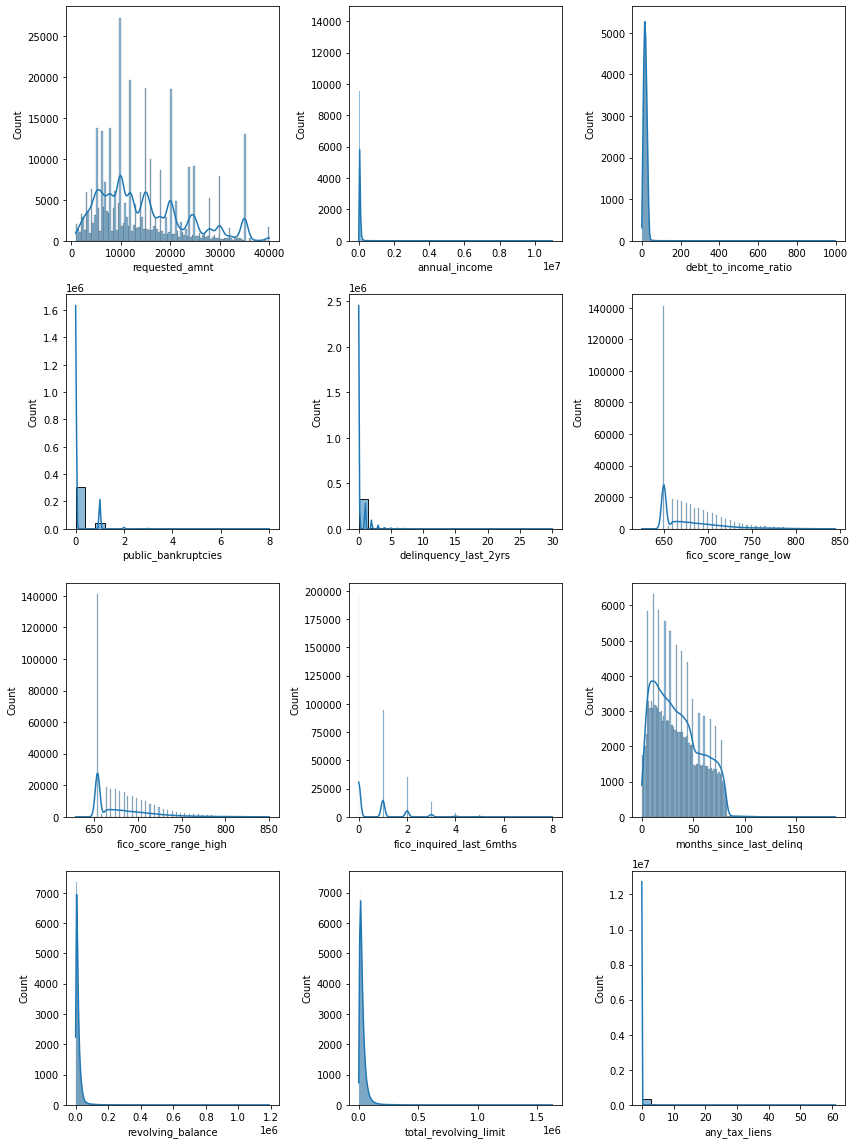

In [ ]:
# test set
columns = ['requested_amnt', 'annual_income', 'debt_to_income_ratio', 'public_bankruptcies',
           'delinquency_last_2yrs', 'fico_score_range_low', 'fico_score_range_high',
           'fico_inquired_last_6mths', 'months_since_last_delinq', 'revolving_balance',
           'total_revolving_limit', 'any_tax_liens']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(test_num_cols_v2[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()          

Most of the distribution are extremely right skewed with the exception of requested_amnt. I will use median to impute the NA values and then apply log transformation to all the columns except requested_amnt.

## Impute Na values

In [15]:
#train_num_cols_v2 
#test_num_cols_v2

columns = ['debt_to_income_ratio', 'public_bankruptcies', 'any_tax_liens']


for col in columns:
    train_num_cols_v2[col] = train_num_cols_v2[col].fillna(train_num_cols_v2[col].median())
    test_num_cols_v2[col] = test_num_cols_v2[col].fillna(test_num_cols_v2[col].median())
    
    
print(train_num_cols_v2.isna().sum())
print('-'*10, '\n')
print(test_num_cols_v2.isna().sum())

requested_amnt                   0
annual_income                    0
debt_to_income_ratio             0
public_bankruptcies              0
delinquency_last_2yrs            0
fico_score_range_low             0
fico_score_range_high            0
fico_inquired_last_6mths         1
months_since_last_delinq    504309
revolving_balance                0
total_revolving_limit        50231
any_tax_liens                    0
loan_paid                        0
dtype: int64
---------- 

requested_amnt                   0
annual_income                    0
debt_to_income_ratio             0
public_bankruptcies              0
delinquency_last_2yrs            0
fico_score_range_low             0
fico_score_range_high            0
fico_inquired_last_6mths         0
months_since_last_delinq    174434
revolving_balance                0
total_revolving_limit        17296
any_tax_liens                    0
dtype: int64


In [16]:
'''
I'm assuming that the missing values in the "months_since_last_delinquency" column indicate that the individual never had a delinquency, 
and I'm replacing it with 0 which is a suitable value to represent the absence of delinquency.
'''

train_num_cols_v2['months_since_last_delinq'].fillna(0, inplace=True)
test_num_cols_v2['months_since_last_delinq'].fillna(0, inplace=True)

## Identify the variables with high correlation scores

- When two or more features are highly correlated, it means that they are providing similar or redundant information to the model. This can result in the model giving undue importance to these features, leading to overfitting and poor generalization to new, unseen data. 

- By dropping highly correlated features, we can reduce the dimensionality of the dataset, simplify the model, and improve its accuracy and generalization.

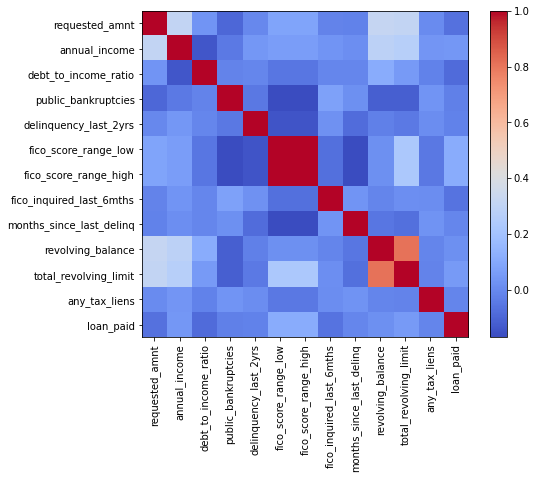

In [17]:
corr_matrix = train_num_cols_v2.corr()

# visualize correlation matrix as a heatmap
fig = plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()

In [18]:
for var1 in corr_matrix.columns:
    for var2 in corr_matrix.columns:
        if (corr_matrix.loc[var1,var2] > 0.8) and (corr_matrix.loc[var1,var2] < 1.0) and (var1 != var2):
            print(f"{var1} and {var2} have a correlation score of {corr_matrix.loc[var1,var2]}")

fico_score_range_low and fico_score_range_high have a correlation score of 0.9999999381189763
fico_score_range_high and fico_score_range_low have a correlation score of 0.9999999381189763
revolving_balance and total_revolving_limit have a correlation score of 0.8087806473016276
total_revolving_limit and revolving_balance have a correlation score of 0.8087806473016276


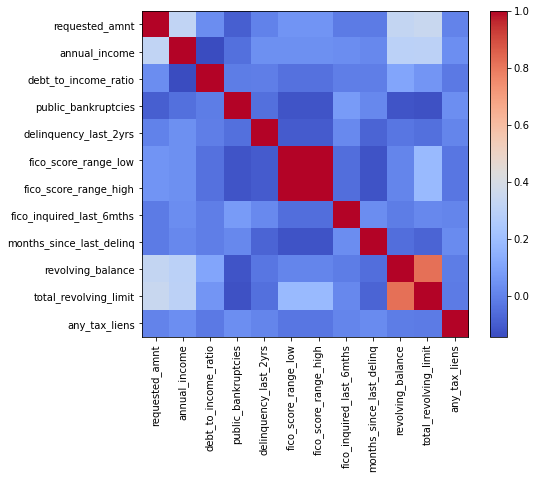

In [19]:
corr_matrix = test_num_cols_v2.corr()

# visualize correlation matrix as a heatmap
fig = plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()

In [20]:
for var1 in corr_matrix.columns:
    for var2 in corr_matrix.columns:
        if (corr_matrix.loc[var1,var2] > 0.8) and (corr_matrix.loc[var1,var2] < 1.0) and (var1 != var2):
            print(f"{var1} and {var2} have a correlation score of {corr_matrix.loc[var1,var2]}")

fico_score_range_low and fico_score_range_high have a correlation score of 0.9999999375194475
fico_score_range_high and fico_score_range_low have a correlation score of 0.9999999375194475
revolving_balance and total_revolving_limit have a correlation score of 0.8175972205684812
total_revolving_limit and revolving_balance have a correlation score of 0.8175972205684812


In [21]:
#drop the fico_score_range_low

train_num_cols_v3 = train_num_cols_v2.drop(['fico_score_range_low'], axis=1) 
test_num_cols_v3 = test_num_cols_v2.drop(['fico_score_range_low'], axis=1)

Since total_revolving_limit and revolving_balance have a correlation score of 0.81, we can leverage this relationship to impute the missing values in total_revolving_limit.
One common approach is to use linear regression to predict the missing values in total_revolving_limit based on the known values in revolving_balance.

In [22]:
# Split the dataset into two subsets: non-missing values and missing values
subset_train = train_num_cols_v3.dropna(subset=['revolving_balance', 'total_revolving_limit'])
subset_missing = train_num_cols_v3[train_num_cols_v3['total_revolving_limit'].isna()]

# Split the subsets into predictor and target variables
revolving_balance_train = subset_train['revolving_balance'].values.reshape(-1, 1)
total_revolving_limit_train = subset_train['total_revolving_limit'].values

revolving_balance_missing = subset_missing['revolving_balance'].values.reshape(-1, 1)

# Fit a linear regression model using the non-missing values
regressor = LinearRegression()
regressor.fit(revolving_balance_train, total_revolving_limit_train)

# Predict the missing values in column B
total_revolving_limit_missing_predicted = regressor.predict(revolving_balance_missing)

# Replace the NA values in column B with the predicted values
train_num_cols_v3.loc[train_num_cols_v3['total_revolving_limit'].isna(), 'total_revolving_limit'] = total_revolving_limit_missing_predicted

In [23]:
# Split the dataset into two subsets: non-missing values and missing values
subset_train = test_num_cols_v3.dropna(subset=['revolving_balance', 'total_revolving_limit'])
subset_missing = test_num_cols_v3[test_num_cols_v3['total_revolving_limit'].isna()]

# Split the subsets into predictor and target variables
revolving_balance_train = subset_train['revolving_balance'].values.reshape(-1, 1)
total_revolving_limit_train = subset_train['total_revolving_limit'].values

revolving_balance_missing = subset_missing['revolving_balance'].values.reshape(-1, 1)

# Fit a linear regression model using the non-missing values
regressor = LinearRegression()
regressor.fit(revolving_balance_train, total_revolving_limit_train)

# Predict the missing values in column B
total_revolving_limit_missing_predicted = regressor.predict(revolving_balance_missing)

# Replace the NA values in column B with the predicted values
test_num_cols_v3.loc[test_num_cols_v3['total_revolving_limit'].isna(), 'total_revolving_limit'] = total_revolving_limit_missing_predicted

In [24]:
# Loop through the rows and ensure total_revolving_limit >= revolving_balance

# Replace row values of total_revolving_limit with revolving_balance if total_revolving_limit < revolving_balance
mask = (train_num_cols_v3['total_revolving_limit'] < train_num_cols_v3['revolving_balance'])
train_num_cols_v3.loc[mask, 'total_revolving_limit'] = train_num_cols_v3.loc[mask, 'revolving_balance']

mask = (test_num_cols_v3['total_revolving_limit'] < test_num_cols_v3['revolving_balance'])
test_num_cols_v3.loc[mask, 'total_revolving_limit'] = test_num_cols_v3.loc[mask, 'revolving_balance']

In [25]:
'''
The calculation of "Total Revolving Limit - Revolving Balance" aims to determine the available credit or remaining credit limit that 
the cardholder has on their credit card account. It represents the amount of credit that the cardholder can still use before reaching their credit limit.

By subtracting the revolving balance from the total revolving limit, you can determine how much of the available credit remains 
for the cardholder to utilize without exceeding their credit limit.

'''

train_num_cols_v3['available_credit'] = train_num_cols_v3['total_revolving_limit'] - train_num_cols_v3['revolving_balance']

test_num_cols_v3['available_credit'] = test_num_cols_v3['total_revolving_limit'] - test_num_cols_v3['revolving_balance']

rows_with_zero_A_train = train_num_cols_v3.loc[train_num_cols_v3['available_credit'] < 0]
rows_with_zero_A_test = test_num_cols_v3.loc[test_num_cols_v3['available_credit'] < 0]

#Ensure that available_credit is always > 0 
print(rows_with_zero_A_train)
print(rows_with_zero_A_test)

Empty DataFrame
Columns: [requested_amnt, annual_income, debt_to_income_ratio, public_bankruptcies, delinquency_last_2yrs, fico_score_range_high, fico_inquired_last_6mths, months_since_last_delinq, revolving_balance, total_revolving_limit, any_tax_liens, loan_paid, available_credit]
Index: []
Empty DataFrame
Columns: [requested_amnt, annual_income, debt_to_income_ratio, public_bankruptcies, delinquency_last_2yrs, fico_score_range_high, fico_inquired_last_6mths, months_since_last_delinq, revolving_balance, total_revolving_limit, any_tax_liens, available_credit]
Index: []


In [26]:
back_up_limit_train = train_num_cols_v3['total_revolving_limit']
back_up_limit_test = test_num_cols_v3['total_revolving_limit']

In [27]:
back_up_limit_train.reset_index(drop=True, inplace=True)
back_up_limit_test.reset_index(drop=True, inplace=True)

In [28]:
train_num_cols_v4 = train_num_cols_v3.drop(['total_revolving_limit'], axis=1) 
test_num_cols_v4 = test_num_cols_v3.drop(['total_revolving_limit'], axis=1) 

In [29]:
print(train_num_cols_v4.isna().sum())
print('-'*10, '\n')
print(test_num_cols_v4.isna().sum())

requested_amnt              0
annual_income               0
debt_to_income_ratio        0
public_bankruptcies         0
delinquency_last_2yrs       0
fico_score_range_high       0
fico_inquired_last_6mths    1
months_since_last_delinq    0
revolving_balance           0
any_tax_liens               0
loan_paid                   0
available_credit            0
dtype: int64
---------- 

requested_amnt              0
annual_income               0
debt_to_income_ratio        0
public_bankruptcies         0
delinquency_last_2yrs       0
fico_score_range_high       0
fico_inquired_last_6mths    0
months_since_last_delinq    0
revolving_balance           0
any_tax_liens               0
available_credit            0
dtype: int64


In [30]:
# In train_num_cols_v3, the minimum value for debt_to_income_ratio is -1 which will cause problem in log transformation
# I'm replacing the -1 to 0 in debt_to_income_ratio

train_num_cols_v4['debt_to_income_ratio'] = train_num_cols_v4['debt_to_income_ratio'].replace(-1, 0)

In [31]:
train_num_cols_v5 = train_num_cols_v4.copy()
test_num_cols_v5 = test_num_cols_v4.copy()

## Perform Log Transformation

In [32]:
# 'requested_amnt' is somewhat uniformly distributed

columns_to_log = ['requested_amnt', 'annual_income', 'debt_to_income_ratio', 'public_bankruptcies', 'delinquency_last_2yrs',
           'fico_score_range_high', 'fico_inquired_last_6mths', 'months_since_last_delinq', 'revolving_balance', 
           'any_tax_liens', 'available_credit']


#loan_numeric_columns_v4 = loan_numeric_columns_v3.copy()

for col in columns_to_log:
    train_num_cols_v5[col] = np.log1p(train_num_cols_v5[col])
    test_num_cols_v5[col] = np.log1p(test_num_cols_v5[col])

## Visulaize Log Distribution

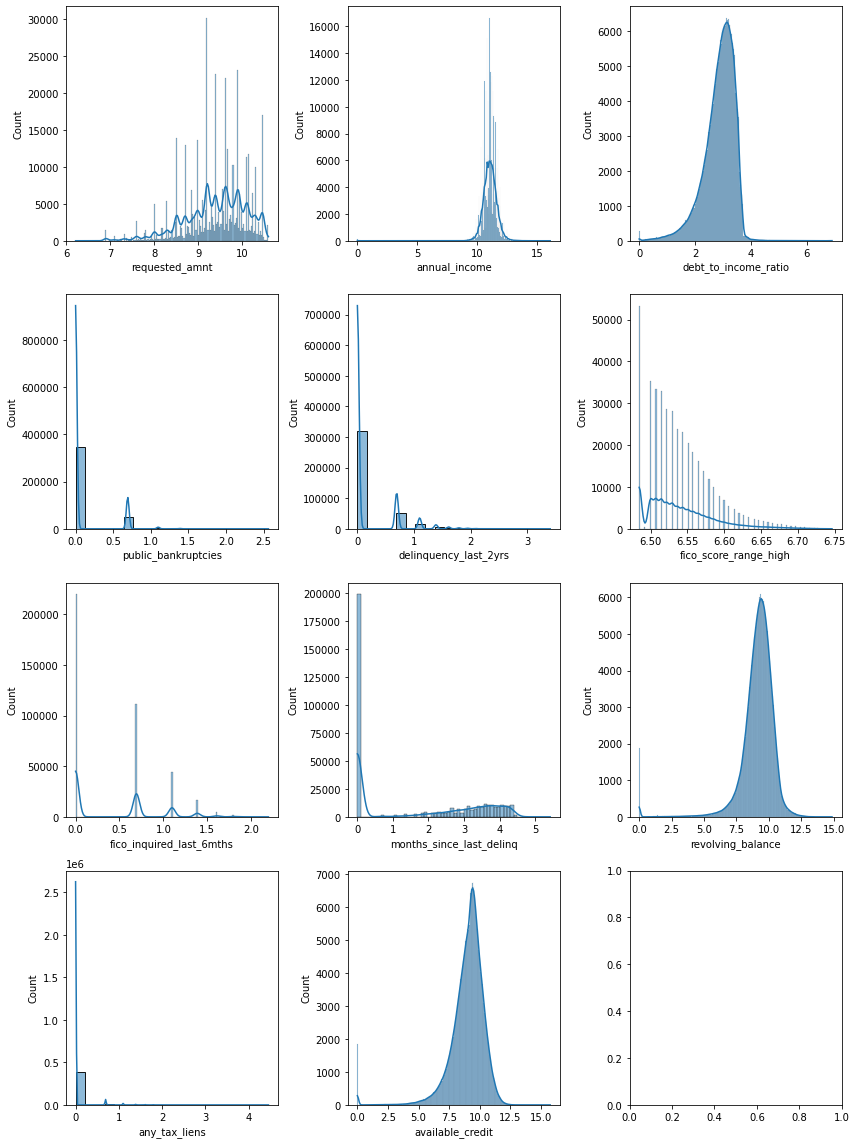

In [145]:
#Train Set

# Define the columns
columns = ['requested_amnt', 'annual_income', 'debt_to_income_ratio', 'public_bankruptcies',
           'delinquency_last_2yrs', 'fico_score_range_high','fico_inquired_last_6mths', 'months_since_last_delinq', 
           'revolving_balance', 'any_tax_liens', 'available_credit']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(train_num_cols_v5[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()          

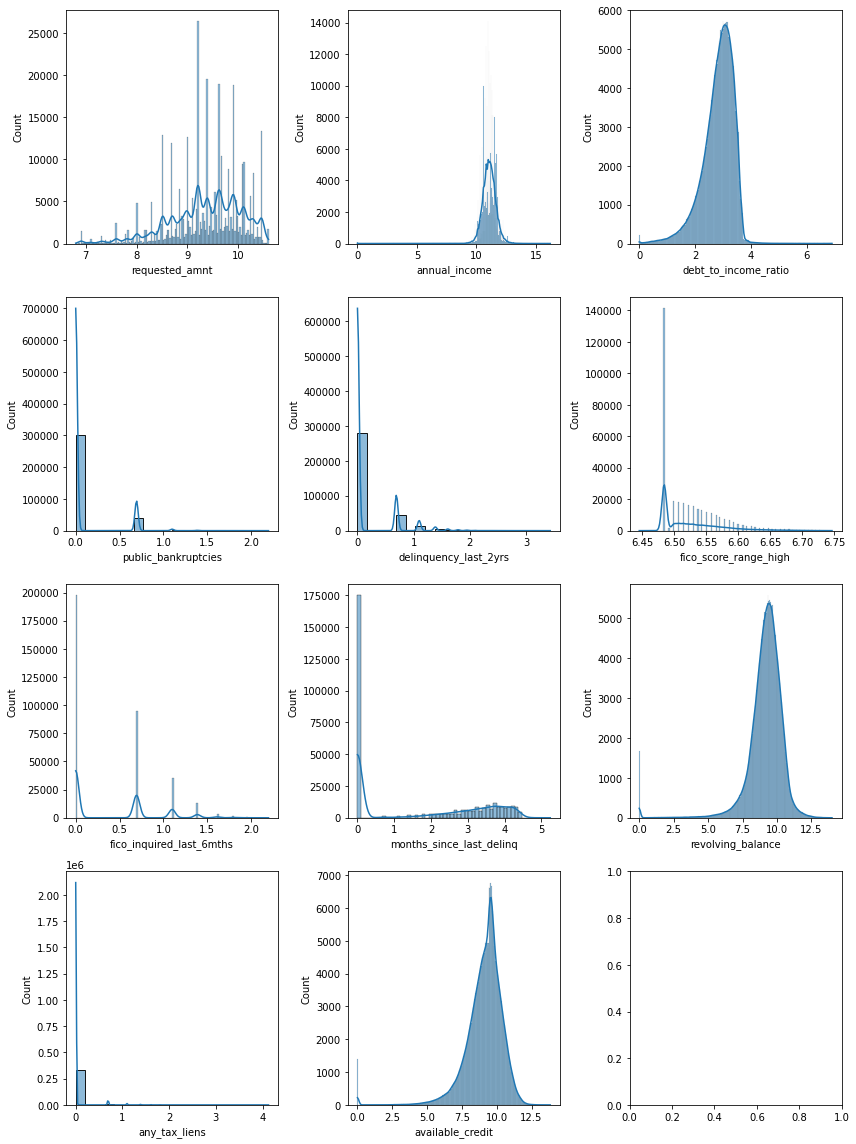

In [146]:
#Test Set

# Define the columns
columns = ['requested_amnt', 'annual_income', 'debt_to_income_ratio', 'public_bankruptcies',
           'delinquency_last_2yrs', 'fico_score_range_high','fico_inquired_last_6mths', 'months_since_last_delinq', 
           'revolving_balance', 'any_tax_liens', 'available_credit']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(test_num_cols_v5[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()         

## Combine Data

In [33]:
train_num_cols_v5.reset_index(drop=True, inplace=True)
test_num_cols_v5.reset_index(drop=True, inplace=True)

train_object_cols_v4.reset_index(drop=True, inplace=True)
test_object_cols_v4.reset_index(drop=True, inplace=True)

In [34]:
print(train_object_cols_v4.nunique(axis=0))
print('-'*10, '\n')
print(test_object_cols_v4.nunique(axis=0))

loan_duration             2
employment_length        11
reason_for_loan          14
employment_verified       3
home_ownership_status     6
type_of_application       2
employment_status         2
extended                  2
dtype: int64
---------- 

loan_duration             2
employment_length        11
reason_for_loan          14
employment_verified       3
home_ownership_status     6
type_of_application       2
employment_status         2
extended                  2
dtype: int64


In [35]:
train_num_cols_v5['fico_inquired_last_6mths'].fillna(train_num_cols_v5['fico_inquired_last_6mths'].median(), inplace=True)

In [36]:
cleaned_train = pd.concat([train_num_cols_v5, train_object_cols_v4], axis=1)
cleaned_test = pd.concat([test_num_cols_v5, test_object_cols_v4], axis=1)

## Model Training

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [38]:
#X = cleaned_train.drop(["loan_paid", "loan_duration", "reason_for_loan"],  axis=1).copy()

X = cleaned_train.drop(["loan_paid"],  axis=1).copy()
y = cleaned_train["loan_paid"].copy()

In [39]:
'''
columns = ['requested_amnt', 'annual_income', 'debt_to_income_ratio', 'public_bankruptcies',
           'delinquency_last_2yrs', 'fico_score_range_high','fico_inquired_last_6mths', 'months_since_last_delinq', 
           'revolving_balance', 'any_tax_liens', 'available_credit']

X = X.loc[:, columns]
'''


"\ncolumns = ['requested_amnt', 'annual_income', 'debt_to_income_ratio', 'public_bankruptcies',\n           'delinquency_last_2yrs', 'fico_score_range_high','fico_inquired_last_6mths', 'months_since_last_delinq', \n           'revolving_balance', 'any_tax_liens', 'available_credit']\n\nX = X.loc[:, columns]\n"

In [40]:

#test_size=0.2 means that 20% of the data will be used for testing and 80% of the data will be used for training. This is a common split size used in machine learning, 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)



# Identify the categorical columns
cat_cols = X.select_dtypes(include='object').columns

# Create a one-hot encoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer object
ct = ColumnTransformer([('one_hot', encoder, cat_cols)], remainder='passthrough')

# Fit the column transformer on the training data
ct.fit(X_train)



# Transform the training and test data
X_train_encoded = ct.transform(X_train)
X_test_encoded = ct.transform(X_test)
y_train = y_train.values
y_test = y_test.values

'''
X_train= X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
'''


'\nX_train= X_train.values\nX_test = X_test.values\ny_train = y_train.values\ny_test = y_test.values\n'

In [41]:
# Get the column names of the encoded data
column_names = ct.get_feature_names_out()

# Print the column names
print(column_names)

['one_hot__loan_duration_ 36 months' 'one_hot__loan_duration_ 60 months'
 'one_hot__employment_length_1 year'
 'one_hot__employment_length_10+ years'
 'one_hot__employment_length_2 years' 'one_hot__employment_length_3 years'
 'one_hot__employment_length_4 years' 'one_hot__employment_length_5 years'
 'one_hot__employment_length_6 years' 'one_hot__employment_length_7 years'
 'one_hot__employment_length_8 years' 'one_hot__employment_length_9 years'
 'one_hot__employment_length_< 1 year' 'one_hot__reason_for_loan_car'
 'one_hot__reason_for_loan_credit_card'
 'one_hot__reason_for_loan_debt_consolidation'
 'one_hot__reason_for_loan_educational'
 'one_hot__reason_for_loan_home_improvement'
 'one_hot__reason_for_loan_house'
 'one_hot__reason_for_loan_major_purchase'
 'one_hot__reason_for_loan_medical' 'one_hot__reason_for_loan_moving'
 'one_hot__reason_for_loan_other'
 'one_hot__reason_for_loan_renewable_energy'
 'one_hot__reason_for_loan_small_business'
 'one_hot__reason_for_loan_vacation' 'o

In [42]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

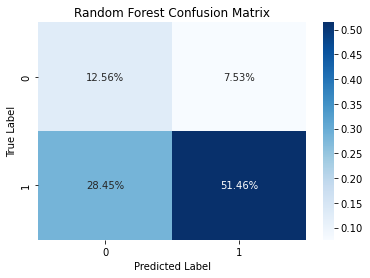

In [43]:
#class_weights = {0: 1, 1: 2}  # Assign higher weight to class 0 (minority class)

lr_model = LogisticRegression(max_iter=500, class_weight = {0: 4, 1: 1})
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)

cf_matrix = confusion_matrix(y_test, lr_pred)

# Visualize confusion matrix using heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# Calculate precision, recall, and F1-score
classification_metrics = classification_report(y_test, lr_pred)

# Print the metrics

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.31      0.63      0.41     40183
           1       0.87      0.64      0.74    159817

    accuracy                           0.64    200000
   macro avg       0.59      0.63      0.58    200000
weighted avg       0.76      0.64      0.67    200000



In [45]:
cleaned_test_encoded = ct.transform(cleaned_test)
cleaned_test_scaled = scaler.transform(cleaned_test_encoded)

In [46]:
lr_prediction = lr_model.predict(cleaned_test_scaled)

submission = pd.DataFrame({ 'ID': final_id,
                            'loan_paid': lr_prediction })


print(submission.dtypes)

ID           int64
loan_paid    int64
dtype: object


In [47]:
submission.to_csv(".../prediction_lr_fd.csv", index=False)

In [48]:
# Get the coefficients
coefficients = lr_model.coef_

# Retrieve the corresponding feature names
#feature_names = ct.get_feature_names_out()

# Create a DataFrame to display the coefficients and feature names
coef_df = pd.DataFrame({"Feature": column_names, "Coefficient": coefficients.flatten()})

# Sort the DataFrame by coefficient magnitude
coef_df = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)

# Print the feature importance
print(coef_df)

                                         Feature  Coefficient
24       one_hot__reason_for_loan_small_business    -0.524128
26              one_hot__reason_for_loan_wedding     0.480775
0              one_hot__loan_duration_ 36 months     0.431149
1              one_hot__loan_duration_ 60 months    -0.431149
49                  remainder__employment_status     0.430468
50                           remainder__extended     0.371980
14          one_hot__reason_for_loan_credit_card     0.366820
43              remainder__fico_score_range_high     0.323369
23     one_hot__reason_for_loan_renewable_energy    -0.301726
31       one_hot__home_ownership_status_MORTGAGE     0.291322
38                     remainder__requested_amnt    -0.273327
13                  one_hot__reason_for_loan_car     0.267804
40               remainder__debt_to_income_ratio    -0.247657
44           remainder__fico_inquired_last_6mths    -0.240337
27     one_hot__employment_verified_Not Verified     0.230754
39      

## PCA

In [49]:
from sklearn.decomposition import PCA

In [50]:
# Create DataFrame for X_train_encoded
X_train_df = pd.DataFrame(X_train_encoded, columns=column_names)
X_test_df = pd.DataFrame(X_test_encoded, columns=column_names)

In [51]:
columns_for_pca_v1 = ['one_hot__loan_duration_ 36 months', 'one_hot__loan_duration_ 60 months']

columns_for_pca_v2 = [  'one_hot__employment_length_1 year',
 'one_hot__employment_length_10+ years',
 'one_hot__employment_length_2 years', 'one_hot__employment_length_3 years',
 'one_hot__employment_length_4 years', 'one_hot__employment_length_5 years',
 'one_hot__employment_length_6 years', 'one_hot__employment_length_7 years',
 'one_hot__employment_length_8 years', 'one_hot__employment_length_9 years',
 'one_hot__employment_length_< 1 year']

columns_for_pca_v3 = ['one_hot__reason_for_loan_car',
 'one_hot__reason_for_loan_credit_card',
 'one_hot__reason_for_loan_debt_consolidation',
 'one_hot__reason_for_loan_educational',
 'one_hot__reason_for_loan_home_improvement',
 'one_hot__reason_for_loan_house',
 'one_hot__reason_for_loan_major_purchase',
 'one_hot__reason_for_loan_medical',
 'one_hot__reason_for_loan_moving',
 'one_hot__reason_for_loan_other',
 'one_hot__reason_for_loan_renewable_energy',
 'one_hot__reason_for_loan_small_business',
 'one_hot__reason_for_loan_vacation',
 'one_hot__reason_for_loan_wedding']

columns_for_pca_v4 = ['one_hot__employment_verified_Not Verified',
 'one_hot__employment_verified_Source Verified',
 'one_hot__employment_verified_Verified'
] 

columns_for_pca_v5 = [ 'one_hot__home_ownership_status_ANY' ,
                      'one_hot__home_ownership_status_MORTGAGE',
 'one_hot__home_ownership_status_NONE',
 'one_hot__home_ownership_status_OTHER',
 'one_hot__home_ownership_status_OWN',
 'one_hot__home_ownership_status_RENT']

columns_for_pca_v6 = [ 'one_hot__type_of_application_Individual',
 'one_hot__type_of_application_Joint App']



In [52]:
to_drop = []
to_drop.extend(columns_for_pca_v1)
to_drop.extend(columns_for_pca_v2)
to_drop.extend(columns_for_pca_v3)
to_drop.extend(columns_for_pca_v4)
to_drop.extend(columns_for_pca_v5)
to_drop.extend(columns_for_pca_v6)

In [53]:
pca1 = PCA(n_components=1)
pca2 = PCA(n_components=1)
pca3 = PCA(n_components=1)
pca4 = PCA(n_components=1)
pca5 = PCA(n_components=1)
pca6 = PCA(n_components=1)

X_train_df['v1'] = pca1.fit_transform(X_train_df[columns_for_pca_v1])
X_train_df['v2'] = pca2.fit_transform(X_train_df[columns_for_pca_v2])
X_train_df['v3'] = pca3.fit_transform(X_train_df[columns_for_pca_v3])
X_train_df['v4'] = pca4.fit_transform(X_train_df[columns_for_pca_v4])
X_train_df['v5'] = pca5.fit_transform(X_train_df[columns_for_pca_v5])
X_train_df['v6'] = pca6.fit_transform(X_train_df[columns_for_pca_v6])


In [54]:
X_test_df['v1'] = pca1.transform(X_test_df[columns_for_pca_v1])
X_test_df['v2'] = pca2.transform(X_test_df[columns_for_pca_v2])
X_test_df['v3'] = pca3.transform(X_test_df[columns_for_pca_v3])
X_test_df['v4'] = pca4.transform(X_test_df[columns_for_pca_v4])
X_test_df['v5'] = pca5.transform(X_test_df[columns_for_pca_v5])
X_test_df['v6'] = pca6.transform(X_test_df[columns_for_pca_v6])

In [55]:
X_test_df_v2 = X_test_df.drop(to_drop, axis=1).copy()

In [56]:
X_train_df_v2  = X_train_df.drop(to_drop,  axis=1).copy()


In [57]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_df_v2)
X_test_scaled = scaler.transform(X_test_df_v2)

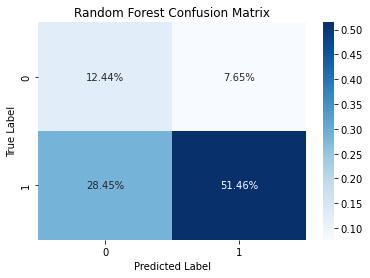

In [58]:
#class_weights = {0: 1, 1: 2}  # Assign higher weight to class 0 (minority class)

lr_model = LogisticRegression(max_iter=500, class_weight={0: 4, 1: 1})
#lr_model.fit(X_train_df_v2.values, y_train)
lr_model.fit(X_train_scaled, y_train)

#lr_pred = lr_model.predict(X_test_df_v2.values)
lr_pred = lr_model.predict(X_test_scaled)

cf_matrix = confusion_matrix(y_test, lr_pred)

# Visualize confusion matrix using heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [59]:
# Calculate precision, recall, and F1-score
classification_metrics = classification_report(y_test, lr_pred)

# Print the metrics

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.30      0.62      0.41     40183
           1       0.87      0.64      0.74    159817

    accuracy                           0.64    200000
   macro avg       0.59      0.63      0.57    200000
weighted avg       0.76      0.64      0.67    200000



In [60]:
cleaned_test_encoded = ct.transform(cleaned_test)
cleaned_test_encoded_df = pd.DataFrame(cleaned_test_encoded, columns=column_names)

In [61]:
cleaned_test_encoded_df['v1'] = pca1.transform(cleaned_test_encoded_df[columns_for_pca_v1])
cleaned_test_encoded_df['v2'] = pca2.transform(cleaned_test_encoded_df[columns_for_pca_v2])
cleaned_test_encoded_df['v3'] = pca3.transform(cleaned_test_encoded_df[columns_for_pca_v3])
cleaned_test_encoded_df['v4'] = pca4.transform(cleaned_test_encoded_df[columns_for_pca_v4])
cleaned_test_encoded_df['v5'] = pca5.transform(cleaned_test_encoded_df[columns_for_pca_v5])
cleaned_test_encoded_df['v6'] = pca6.transform(cleaned_test_encoded_df[columns_for_pca_v6])

In [62]:
cleaned_test_encoded_df_v2 = cleaned_test_encoded_df.drop(to_drop,  axis=1).copy()

In [63]:
cleaned_test_scaled = scaler.transform(cleaned_test_encoded_df_v2)

In [64]:
lr_prediction = lr_model.predict(cleaned_test_scaled)

submission = pd.DataFrame({ 'ID': final_id,
                            'loan_paid': lr_prediction })

print(submission.dtypes)

ID           int64
loan_paid    int64
dtype: object


In [65]:
submission.to_csv(".../prediction_lr_pca.csv", index=False)

## SMOTE

In [66]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [67]:
X_test_scaled_smote = X_test_scaled.copy()
y_test_smote = y_test.copy()

In [82]:
print(X_train_resampled)

[[-1.51279263e+00 -6.45648432e-01 -5.56751286e-01 ... -7.36180089e-02
  -5.26697440e-01  2.20285495e-10]
 [ 5.12949474e-01  3.06978098e-01  3.16365817e-01 ... -1.12999498e-10
  -5.26697441e-01  0.00000000e+00]
 [ 1.16826923e+00  6.66155484e-01  3.71551765e-01 ... -7.36180089e-02
  -5.26697441e-01  0.00000000e+00]
 ...
 [-4.33631718e-01 -6.26977101e-01 -3.84374926e-01 ...  0.00000000e+00
   4.73302559e-01  0.00000000e+00]
 [ 9.36658261e-01  4.57000877e-01  1.26355387e-01 ...  9.26381991e-01
   4.73302559e-01  0.00000000e+00]
 [ 1.06325119e+00  8.35261081e-01  9.12647465e-02 ...  9.26381991e-01
   4.73302559e-01  0.00000000e+00]]


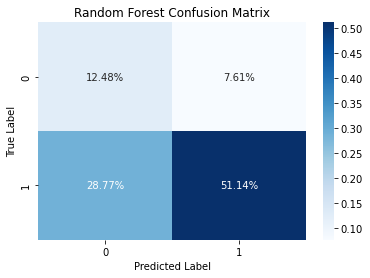

In [76]:
#class_weights = {0: 1, 1: 2}  # Assign higher weight to class 0 (minority class)

lr_model_smote = LogisticRegression(max_iter=1500 )

lr_model_smote.fit(X_train_resampled.values, y_train_resampled.values)

#lr_pred = lr_model.predict(X_test_df_v2.values)
lr_pred_smote = lr_model_smote.predict(X_test_scaled_smote.values)

cf_matrix = confusion_matrix(y_test_smote, lr_pred_smote)

# Visualize confusion matrix using heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [77]:
# Calculate precision, recall, and F1-score
classification_metrics = classification_report(y_test_smote, lr_pred_smote)

# Print the metrics

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.30      0.62      0.41     40183
           1       0.87      0.64      0.74    159817

    accuracy                           0.64    200000
   macro avg       0.59      0.63      0.57    200000
weighted avg       0.76      0.64      0.67    200000



In [78]:
lr_prediction_smote = lr_model_smote.predict(cleaned_test_scaled)

submission = pd.DataFrame({ 'ID': final_id,
                            'loan_paid': lr_prediction_smote })

print(submission.dtypes)

ID           int64
loan_paid    int64
dtype: object


In [79]:
submission.to_csv(".../prediction_lr_pca_smote.csv", index=False)

## ADASYN

In [81]:
from imblearn.over_sampling import ADASYN

# Instantiate the ADASYN sampler
adasyn = ADASYN(random_state=42)

# Apply ADASYN to the imbalanced dataset
X_resampled_ADASYN, y_resampled_ADASYN = adasyn.fit_resample(X_train_scaled, y_train)

In [84]:
X_test_scaled_ADASYN = X_test_scaled.copy()
y_test_ADASYN = y_test.copy()

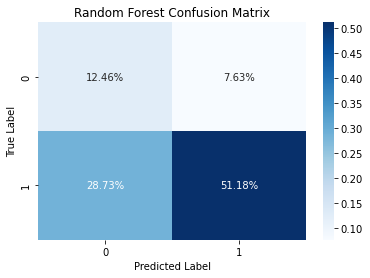

In [85]:
#class_weights = {0: 1, 1: 2}  # Assign higher weight to class 0 (minority class)

lr_model_ADASYN = LogisticRegression(max_iter=1500)
#lr_model.fit(X_train_df_v2.values, y_train)
lr_model_ADASYN.fit(X_resampled_ADASYN, y_resampled_ADASYN)

#lr_pred = lr_model.predict(X_test_df_v2.values)
lr_pred_ADASYN = lr_model_ADASYN.predict(X_test_scaled_ADASYN)

cf_matrix = confusion_matrix(y_test_ADASYN, lr_pred_ADASYN)

# Visualize confusion matrix using heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [86]:
# Calculate precision, recall, and F1-score
classification_metrics = classification_report(y_test_ADASYN, lr_pred_ADASYN)

# Print the metrics

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.30      0.62      0.41     40183
           1       0.87      0.64      0.74    159817

    accuracy                           0.64    200000
   macro avg       0.59      0.63      0.57    200000
weighted avg       0.76      0.64      0.67    200000



In [87]:
lr_prediction_ADASYN = lr_model_ADASYN.predict(cleaned_test_scaled)

submission = pd.DataFrame({ 'ID': final_id,
                            'loan_paid': lr_prediction_smote })

print(submission.dtypes)

ID           int64
loan_paid    int64
dtype: object


In [88]:
submission.to_csv(".../prediction_lr_pca_ADASYN.csv", index=False)

In [99]:
# Obtain predicted probabilities for the positive class
y_probabilities = lr_model_ADASYN.predict_proba(X_test_scaled_ADASYN)[:, 1]

# Lower the threshold (e.g., to 0.3) to increase recall
lowered_threshold_predictions = (y_probabilities >= 0.3).astype(int)

# Evaluate the performance of the model with the adjusted threshold
recall = recall_score(y_test, lowered_threshold_predictions)
precision = precision_score(y_test, lowered_threshold_predictions)
accuracy = accuracy_score(y_test, lowered_threshold_predictions)
f1 = f1_score(y_test, lowered_threshold_predictions)

print("Recall:", recall)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Recall: 0.9612431718778353
Precision: 0.8155082626859967
Accuracy: 0.79526
F1 Score: 0.8823988925713826


In [106]:
# Obtain predicted probabilities for the positive class
sub_probabilities = lr_model_ADASYN.predict_proba(cleaned_test_scaled)[:, 1]

# Lower the threshold (e.g., to 0.3) to increase recall
sub_lowered_threshold_predictions = (sub_probabilities >= 0.2).astype(int)

In [107]:
submission = pd.DataFrame({ 'ID': final_id,
                            'loan_paid': sub_lowered_threshold_predictions})

In [108]:
submission.to_csv(".../prediction_lr_pca_ADASYN_lower.csv", index=False)

## NearMiss

In [91]:
from imblearn.under_sampling import NearMiss

# Instantiate the NearMiss sampler
near_miss = NearMiss(version=1)

# Apply NearMiss to the imbalanced dataset
X_resampled_NM, y_resampled_NM = near_miss.fit_resample(X_train_scaled, y_train)



In [92]:
X_test_scaled_NM = X_test_scaled.copy()
y_test_NM = y_test.copy()

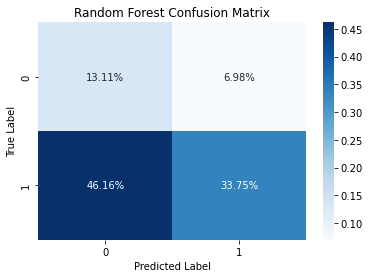

In [93]:
#class_weights = {0: 1, 1: 2}  # Assign higher weight to class 0 (minority class)

lr_model_NM = LogisticRegression(max_iter=1500 )
#lr_model.fit(X_train_df_v2.values, y_train)
lr_model_NM.fit(X_resampled_NM, y_resampled_NM)

#lr_pred = lr_model.predict(X_test_df_v2.values)
lr_pred_NM = lr_model_NM.predict(X_test_scaled_NM)

cf_matrix = confusion_matrix(y_test_NM, lr_pred_NM)

# Visualize confusion matrix using heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [94]:
# Calculate precision, recall, and F1-score
classification_metrics = classification_report(y_test_NM, lr_pred_NM)

# Print the metrics

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.22      0.65      0.33     40183
           1       0.83      0.42      0.56    159817

    accuracy                           0.47    200000
   macro avg       0.52      0.54      0.44    200000
weighted avg       0.71      0.47      0.51    200000



In [95]:
submission.to_csv(".../prediction_lr_pca_NM.csv", index=False)

In [98]:

# Obtain predicted probabilities for the positive class
y_probabilities = lr_model_NM.predict_proba(X_test_scaled_NM)[:, 1]

# Lower the threshold (e.g., to 0.3) to increase recall
lowered_threshold_predictions = (y_probabilities >= 0.3).astype(int)

# Evaluate the performance of the model with the adjusted threshold
recall = recall_score(y_test, lowered_threshold_predictions)
precision = precision_score(y_test, lowered_threshold_predictions)
accuracy = accuracy_score(y_test, lowered_threshold_predictions)
f1 = f1_score(y_test, lowered_threshold_predictions)

print("Recall:", recall)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1 Score:", f1)


Recall: 0.6549115550911355
Precision: 0.8184576406374626
Accuracy: 0.608165
F1 Score: 0.7276076732974394


## Feature Engineering

In [738]:
#Starts with v4 before log transformation

train_num_cols_v4_f = train_num_cols_v4.copy()
test_num_cols_v4_f = test_num_cols_v4.copy()

train_object_cols_v4_f = train_object_cols_v4.copy()
test_object_cols_v4_f = test_object_cols_v4.copy()

In [739]:
train_num_cols_v4_f.reset_index(drop=True, inplace=True)
test_num_cols_v4_f.reset_index(drop=True, inplace=True)

train_num_cols_v4_f.reset_index(drop=True, inplace=True)
test_object_cols_v4_f.reset_index(drop=True, inplace=True)

In [740]:
cleaned_train_v2 = pd.concat([train_num_cols_v4_f, train_object_cols_v4_f], axis=1)
cleaned_test_v2 = pd.concat([test_num_cols_v4_f, test_object_cols_v4_f], axis=1)

In [741]:
cleaned_train_v2.head()

,requested_amnt,annual_income,debt_to_income_ratio,public_bankruptcies,delinquency_last_2yrs,fico_score_range_high,fico_inquired_last_6mths,months_since_last_delinq,revolving_balance,any_tax_liens,loan_paid,available_credit,loan_duration,employment_length,reason_for_loan,employment_verified,home_ownership_status,type_of_application,employment_status,extended
0,8000.0,40000.0,29.12,0.0,0.0,679.0,1.0,0.0,14958.0,0.0,1,4142.0,36 months,3 years,credit_card,Not Verified,RENT,Individual,1,1
1,22000.0,50000.0,24.48,0.0,0.0,699.0,0.0,0.0,14505.0,0.0,0,4095.0,60 months,10+ years,credit_card,Verified,RENT,Individual,1,1
2,5650.0,30000.0,16.08,0.0,0.0,749.0,2.0,0.0,3354.0,0.0,0,19746.0,36 months,7 years,debt_consolidation,Not Verified,RENT,Individual,1,1
3,32000.0,135000.0,14.65,0.0,1.0,679.0,1.0,9.0,13262.0,0.0,1,838.0,60 months,10+ years,debt_consolidation,Verified,MORTGAGE,Individual,1,1
4,10000.0,37000.0,15.60,0.0,0.0,674.0,2.0,0.0,9588.0,0.0,0,2912.0,36 months,5 years,debt_consolidation,Not Verified,RENT,Individual,1,1


In [742]:
cleaned_test_v2.describe()


,requested_amnt,annual_income,debt_to_income_ratio,public_bankruptcies,delinquency_last_2yrs,fico_score_range_high,fico_inquired_last_6mths,months_since_last_delinq,revolving_balance,any_tax_liens,available_credit,employment_status,extended
count,345310.000000,3.453100e+05,345310.000000,345310.000000,345310.000000,345310.000000,345310.000000,345310.000000,3.453100e+05,345310.000000,3.453100e+05,345310.000000,345310.000000
mean,14410.926269,7.615687e+04,18.300866,0.134265,0.315800,680.754922,0.655585,16.989511,1.623582e+04,0.051348,1.640089e+04,0.941513,0.987739
std,8711.505197,6.780792e+04,11.187385,0.378318,0.871392,32.970583,0.937612,23.066987,2.177037e+04,0.409619,1.942082e+04,0.234662,0.110051
min,900.000000,0.000000e+00,0.000000,0.000000,0.000000,629.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,8000.000000,4.576000e+04,11.810000,0.000000,0.000000,654.000000,0.000000,0.000000,5.951000e+03,0.000000,4.980000e+03,1.000000,1.000000
50%,12000.000000,6.500000e+04,17.630000,0.000000,0.000000,669.000000,0.000000,0.000000,1.112800e+04,0.000000,1.109100e+04,1.000000,1.000000
75%,20000.000000,9.000000e+04,24.080000,0.000000,0.000000,699.000000,1.000000,31.000000,1.973600e+04,0.000000,2.016200e+04,1.000000,1.000000
max,40000.000000,1.099920e+07,999.000000,8.000000,30.000000,850.000000,8.000000,188.000000,1.190046e+06,61.000000,1.028381e+06,1.000000,1.000000


In [743]:
print(cleaned_train_v2.isnull().sum())

requested_amnt              0
annual_income               0
debt_to_income_ratio        0
public_bankruptcies         0
delinquency_last_2yrs       0
fico_score_range_high       0
fico_inquired_last_6mths    0
months_since_last_delinq    0
revolving_balance           0
any_tax_liens               0
loan_paid                   0
available_credit            0
loan_duration               0
employment_length           0
reason_for_loan             0
employment_verified         0
home_ownership_status       0
type_of_application         0
employment_status           0
extended                    0
dtype: int64


In [744]:
cleaned_train_v2['loan_duration'] = cleaned_train_v2['loan_duration'].str.rstrip(' months').astype(int)
cleaned_test_v2['loan_duration'] = cleaned_test_v2['loan_duration'].str.rstrip(' months').astype(int)

In [745]:
cleaned_train_v2['monthly_loan_payment'] = cleaned_train_v2['requested_amnt'] / cleaned_train_v2['loan_duration']
cleaned_test_v2['monthly_loan_payment'] = cleaned_test_v2['requested_amnt'] / cleaned_test_v2['loan_duration']

In [746]:
cleaned_train_v2['monthly_income'] = cleaned_train_v2['annual_income'] / 12
cleaned_test_v2['monthly_income'] = cleaned_test_v2['annual_income'] / 12

In [747]:
cleaned_train_v2['monthly_debt'] = (cleaned_train_v2['monthly_income'] * cleaned_train_v2['debt_to_income_ratio']) / 100
cleaned_test_v2['monthly_debt'] = (cleaned_test_v2['monthly_income'] * cleaned_test_v2['debt_to_income_ratio']) / 100

In [748]:
cleaned_train_v2['total_revolving_limit'] = back_up_limit_train          #Bring back total revolving limit
cleaned_test_v2['total_revolving_limit'] = back_up_limit_test            #Bring back total revolving limit

cleaned_train_v2["total_revolving_limit"] = cleaned_train_v2["total_revolving_limit"].replace(0, 1)
cleaned_test_v2["total_revolving_limit"] = cleaned_test_v2["total_revolving_limit"].replace(0, 1)

# credit_usage_ratio = revolving_balance / total_revolving_limit

cleaned_train_v2['credit_usage_ratio'] = cleaned_train_v2['revolving_balance'] / cleaned_train_v2['total_revolving_limit']
cleaned_test_v2['credit_usage_ratio'] = cleaned_test_v2['revolving_balance'] / cleaned_test_v2['total_revolving_limit']

In [749]:
cleaned_train_v2['remaining_income'] = cleaned_train_v2['monthly_income'] - cleaned_train_v2['monthly_debt'] - cleaned_train_v2['monthly_loan_payment'] 
cleaned_test_v2['remaining_income'] = cleaned_test_v2['monthly_income'] - cleaned_test_v2['monthly_debt'] - cleaned_test_v2['monthly_loan_payment'] 

In [750]:
cleaned_train_v2['monthly_income_to_debt_ratio'] = cleaned_train_v2['monthly_income'] / (cleaned_train_v2['monthly_debt'] + cleaned_train_v2['monthly_loan_payment']) * 100
cleaned_test_v2['monthly_income_to_debt_ratio'] = cleaned_test_v2['monthly_income'] / (cleaned_test_v2['monthly_debt'] + cleaned_test_v2['monthly_loan_payment']) * 100

In [751]:
cleaned_train_v2['credit_cover_loan'] = cleaned_train_v2['monthly_loan_payment'] -  cleaned_train_v2['available_credit'] 
cleaned_test_v2['credit_cover_loan'] = cleaned_test_v2['monthly_loan_payment'] -  cleaned_test_v2['available_credit'] 

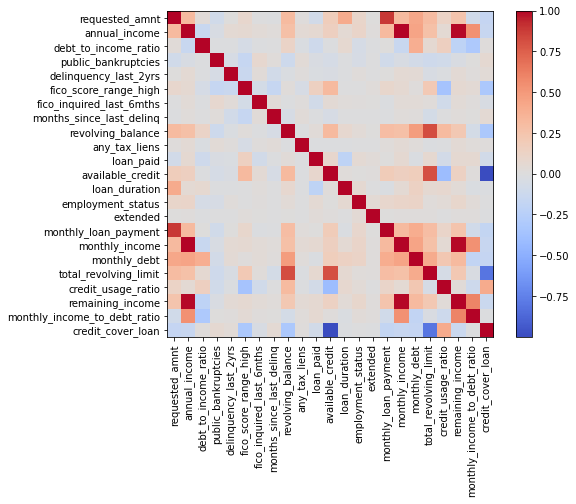

In [752]:
corr_matrix = cleaned_train_v2.corr()

# visualize correlation matrix as a heatmap
fig = plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()

In [753]:
print(cleaned_train_v2.shape)
print('-'*10, '\n')
print(cleaned_test_v2.shape)

(400260, 28)
---------- 

(345310, 27)


In [754]:
loan_paid_corr = corr_matrix['loan_paid']
print(loan_paid_corr)

requested_amnt                 -0.081240
annual_income                   0.054757
debt_to_income_ratio           -0.104952
public_bankruptcies            -0.031379
delinquency_last_2yrs          -0.024135
fico_score_range_high           0.147411
fico_inquired_last_6mths       -0.080613
months_since_last_delinq       -0.009932
revolving_balance               0.026222
any_tax_liens                  -0.012650
loan_paid                       1.000000
available_credit                0.081485
loan_duration                  -0.206807
employment_status               0.051091
extended                        0.028090
monthly_loan_payment            0.005318
monthly_income                  0.054757
monthly_debt                   -0.024664
total_revolving_limit           0.066252
credit_usage_ratio             -0.073283
remaining_income                0.061435
monthly_income_to_debt_ratio    0.058506
credit_cover_loan              -0.081575
Name: loan_paid, dtype: float64


In [755]:
for var1 in corr_matrix.columns:
    for var2 in corr_matrix.columns:
        if (corr_matrix.loc[var1,var2] > 0.8) and (corr_matrix.loc[var1,var2] < 1.0) and (var1 != var2):
            print(f"{var1} and {var2} have a correlation score of {corr_matrix.loc[var1,var2]}")

requested_amnt and monthly_loan_payment have a correlation score of 0.8880858947329819
annual_income and remaining_income have a correlation score of 0.990266831277412
revolving_balance and total_revolving_limit have a correlation score of 0.8128656707984244
available_credit and total_revolving_limit have a correlation score of 0.8107998235233025
monthly_loan_payment and requested_amnt have a correlation score of 0.8880858947329819
monthly_income and remaining_income have a correlation score of 0.9902668312774165
total_revolving_limit and revolving_balance have a correlation score of 0.8128656707984244
total_revolving_limit and available_credit have a correlation score of 0.8107998235233025
remaining_income and annual_income have a correlation score of 0.990266831277412
remaining_income and monthly_income have a correlation score of 0.9902668312774165


In [756]:
cleaned_train_v3 = cleaned_train_v2.drop(['annual_income', 'monthly_income', 'monthly_loan_payment', 'loan_duration'], axis=1)
cleaned_test_v3 = cleaned_test_v2.drop(['annual_income', 'monthly_income', 'monthly_loan_payment', 'loan_duration'], axis=1)

In [757]:
print(cleaned_train_v3.isnull().sum())

requested_amnt                  0
debt_to_income_ratio            0
public_bankruptcies             0
delinquency_last_2yrs           0
fico_score_range_high           0
fico_inquired_last_6mths        0
months_since_last_delinq        0
revolving_balance               0
any_tax_liens                   0
loan_paid                       0
available_credit                0
employment_length               0
reason_for_loan                 0
employment_verified             0
home_ownership_status           0
type_of_application             0
employment_status               0
extended                        0
monthly_debt                    0
total_revolving_limit           0
credit_usage_ratio              0
remaining_income                0
monthly_income_to_debt_ratio    0
credit_cover_loan               0
dtype: int64


In [758]:
print(cleaned_train_v3.shape) # loan_paid in training set
print('-'*10, '\n')
print(cleaned_test_v3.shape)

(400260, 24)
---------- 

(345310, 23)


In [759]:
cleaned_train_v3.describe()

,requested_amnt,debt_to_income_ratio,public_bankruptcies,delinquency_last_2yrs,fico_score_range_high,fico_inquired_last_6mths,months_since_last_delinq,revolving_balance,any_tax_liens,loan_paid,available_credit,employment_status,extended,monthly_debt,total_revolving_limit,credit_usage_ratio,remaining_income,monthly_income_to_debt_ratio,credit_cover_loan
count,400260.000000,400260.000000,400260.000000,400260.000000,400260.000000,400260.000000,400260.000000,4.002600e+05,400260.000000,400260.000000,4.002600e+05,400260.000000,400260.000000,400260.000000,4.002600e+05,400260.000000,400260.000000,400260.000000,4.002600e+05
mean,14858.439577,18.973500,0.141343,0.331257,691.259446,0.697801,17.140589,1.593389e+04,0.055259,0.500000,1.532529e+04,0.935065,0.985522,1081.793535,3.125918e+04,0.524745,4745.972328,498.165520,-1.497960e+04
std,8776.243556,11.240338,0.387275,0.903815,31.653393,0.964598,23.073619,2.159064e+04,0.408835,0.500001,2.148469e+04,0.246412,0.119451,718.161879,3.497008e+04,0.240727,5207.757345,623.421713,2.144784e+04
min,1000.000000,0.000000,0.000000,0.000000,654.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000,-3227.888889,0.000000,-7.438568e+06
25%,8000.000000,12.400000,0.000000,0.000000,669.000000,0.000000,0.000000,5.959000e+03,0.000000,0.000000,4.720000e+03,1.000000,1.000000,598.216667,1.389917e+04,0.347992,2670.575000,311.164846,-1.857236e+04
50%,13000.000000,18.390000,0.000000,0.000000,684.000000,0.000000,1.000000,1.112100e+04,0.000000,0.500000,1.036500e+04,1.000000,1.000000,940.333333,2.330000e+04,0.527931,3881.333333,403.682382,-1.004967e+04
75%,20000.000000,24.920000,0.000000,0.000000,709.000000,1.000000,31.000000,1.950900e+04,0.000000,1.000000,1.894200e+04,1.000000,1.000000,1399.291667,3.860000e+04,0.708378,5687.457188,557.828189,-4.411444e+03
max,40000.000000,999.000000,11.000000,27.000000,850.000000,8.000000,226.000000,2.560703e+06,85.000000,1.000000,7.439296e+06,1.000000,1.000000,22718.750000,9.999999e+06,1.000000,790316.666667,199570.815451,1.111111e+03


In [760]:
cleaned_test_v3.describe()

,requested_amnt,debt_to_income_ratio,public_bankruptcies,delinquency_last_2yrs,fico_score_range_high,fico_inquired_last_6mths,months_since_last_delinq,revolving_balance,any_tax_liens,available_credit,employment_status,extended,monthly_debt,total_revolving_limit,credit_usage_ratio,remaining_income,monthly_income_to_debt_ratio,credit_cover_loan
count,345310.000000,345310.000000,345310.000000,345310.000000,345310.000000,345310.000000,345310.000000,3.453100e+05,345310.000000,3.453100e+05,345310.000000,345310.000000,345310.000000,3.453100e+05,345310.000000,345310.000000,345310.000000,3.453100e+05
mean,14410.926269,18.300866,0.134265,0.315800,680.754922,0.655585,16.989511,1.623582e+04,0.051348,1.640089e+04,0.941513,0.987739,1070.057351,3.263671e+04,0.513715,4930.210322,519.268264,-1.605475e+04
std,8711.505197,11.187385,0.378318,0.871392,32.970583,0.937612,23.066987,2.177037e+04,0.409619,1.942082e+04,0.234662,0.110051,721.966455,3.280520e+04,0.242682,5309.793085,699.743538,1.937590e+04
min,900.000000,0.000000,0.000000,0.000000,629.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000,-3222.083333,0.000000,-1.027798e+06
25%,8000.000000,11.810000,0.000000,0.000000,654.000000,0.000000,0.000000,5.951000e+03,0.000000,4.980000e+03,1.000000,1.000000,584.583333,1.440000e+04,0.333358,2764.896875,320.935706,-1.978530e+04
50%,12000.000000,17.630000,0.000000,0.000000,669.000000,0.000000,0.000000,1.112800e+04,0.000000,1.109100e+04,1.000000,1.000000,926.875000,2.410000e+04,0.515103,4037.427778,419.542806,-1.074733e+04
75%,20000.000000,24.080000,0.000000,0.000000,699.000000,1.000000,31.000000,1.973600e+04,0.000000,2.016200e+04,1.000000,1.000000,1385.000000,4.030000e+04,0.698756,5913.953101,584.023497,-4.673694e+03
max,40000.000000,999.000000,8.000000,30.000000,850.000000,8.000000,188.000000,1.190046e+06,61.000000,1.028381e+06,1.000000,1.000000,28774.166667,1.629000e+06,1.000000,915819.491111,264705.882353,9.722222e+02


In [761]:
# Identify numeric columns (excluding 'loan_paid')
numeric_cols = cleaned_train_v3.select_dtypes(include=np.number).columns
numeric_cols = [col for col in numeric_cols if col != 'loan_paid']

# Select numeric columns without negative values
selected_cols = [col for col in numeric_cols if (cleaned_train_v3[col] >= 0).all()]

# Perform log transformation on numeric columns
for col in selected_cols:
    if col != 'loan_paid':
        cleaned_train_v3[col] = np.log(cleaned_train_v3[col] + 1e-10) #handle zero
        cleaned_test_v3[col] = np.log(cleaned_test_v3[col] + 1e-10)

## Second Model Training

In [762]:
X_v2 = cleaned_train_v3.drop(["loan_paid"],  axis=1).copy()

#X = cleaned_train.drop(["loan_paid"],  axis=1).copy()
y_v2 = cleaned_train_v3["loan_paid"].copy()

In [763]:
print(X_v2.dtypes)

requested_amnt                  float64
debt_to_income_ratio            float64
public_bankruptcies             float64
delinquency_last_2yrs           float64
fico_score_range_high           float64
fico_inquired_last_6mths        float64
months_since_last_delinq        float64
revolving_balance               float64
any_tax_liens                   float64
available_credit                float64
employment_length                object
reason_for_loan                  object
employment_verified              object
home_ownership_status            object
type_of_application              object
employment_status               float64
extended                        float64
monthly_debt                    float64
total_revolving_limit           float64
credit_usage_ratio              float64
remaining_income                float64
monthly_income_to_debt_ratio    float64
credit_cover_loan               float64
dtype: object


In [764]:
print(X_v2.isnull().sum())

requested_amnt                  0
debt_to_income_ratio            0
public_bankruptcies             0
delinquency_last_2yrs           0
fico_score_range_high           0
fico_inquired_last_6mths        0
months_since_last_delinq        0
revolving_balance               0
any_tax_liens                   0
available_credit                0
employment_length               0
reason_for_loan                 0
employment_verified             0
home_ownership_status           0
type_of_application             0
employment_status               0
extended                        0
monthly_debt                    0
total_revolving_limit           0
credit_usage_ratio              0
remaining_income                0
monthly_income_to_debt_ratio    0
credit_cover_loan               0
dtype: int64


In [766]:
#test_size=0.2 means that 20% of the data will be used for testing and 80% of the data will be used for training. This is a common split size used in machine learning, 

X_train, X_test, y_train, y_test = train_test_split(X_v2, y_v2, test_size=0.2, random_state=21)


# Identify the categorical columns
cat_cols = X_v2.select_dtypes(include='object').columns

# Create a one-hot encoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer object
ct = ColumnTransformer([('one_hot', encoder, cat_cols)], remainder='passthrough')

# Fit the column transformer on the training data
ct.fit(X_train)

# Transform the training and test data
X_train_encoded = ct.transform(X_train)
X_test_encoded = ct.transform(X_test)
y_train = y_train.values
y_test = y_test.values


'''
X_train= X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
'''

'\nX_train= X_train.values\nX_test = X_test.values\ny_train = y_train.values\ny_test = y_test.values\n'

In [767]:
# Get the column names of the encoded data
column_names = ct.get_feature_names_out()

# Print the column names
print(column_names)

['one_hot__employment_length_1 year'
 'one_hot__employment_length_10+ years'
 'one_hot__employment_length_2 years' 'one_hot__employment_length_3 years'
 'one_hot__employment_length_4 years' 'one_hot__employment_length_5 years'
 'one_hot__employment_length_6 years' 'one_hot__employment_length_7 years'
 'one_hot__employment_length_8 years' 'one_hot__employment_length_9 years'
 'one_hot__employment_length_< 1 year' 'one_hot__reason_for_loan_car'
 'one_hot__reason_for_loan_credit_card'
 'one_hot__reason_for_loan_debt_consolidation'
 'one_hot__reason_for_loan_educational'
 'one_hot__reason_for_loan_home_improvement'
 'one_hot__reason_for_loan_house'
 'one_hot__reason_for_loan_major_purchase'
 'one_hot__reason_for_loan_medical' 'one_hot__reason_for_loan_moving'
 'one_hot__reason_for_loan_other'
 'one_hot__reason_for_loan_renewable_energy'
 'one_hot__reason_for_loan_small_business'
 'one_hot__reason_for_loan_vacation' 'one_hot__reason_for_loan_wedding'
 'one_hot__employment_verified_Not Verif

In [769]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.fit_transform(X_test_encoded)

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


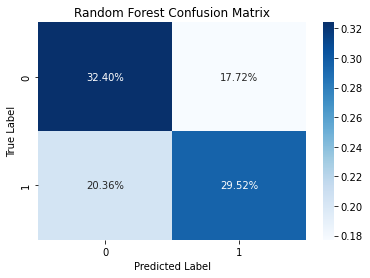

In [770]:
#class_weights = {0: 1, 1: 2}  # Assign higher weight to class 0 (minority class)

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)

cf_matrix = confusion_matrix(y_test, lr_pred)

# Visualize confusion matrix using heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [771]:
# Calculate precision, recall, and F1-score
classification_metrics = classification_report(y_test, lr_pred)

# Print the metrics

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.61      0.65      0.63     40124
           1       0.62      0.59      0.61     39928

    accuracy                           0.62     80052
   macro avg       0.62      0.62      0.62     80052
weighted avg       0.62      0.62      0.62     80052



In [773]:
cleaned_test_encoded = ct.transform(cleaned_test_v3)
cleaned_test_scaled = scaler.transform(cleaned_test_encoded)

In [774]:
lr_prediction = lr_model.predict(cleaned_test_scaled)

submission = pd.DataFrame({ 'ID': final_id,
                            'loan_paid': lr_prediction })


print(submission.dtypes)

ID           int64
loan_paid    int64
dtype: object


In [775]:
submission.to_csv(".../model_training_v2/prediction_lr.csv", index=False)

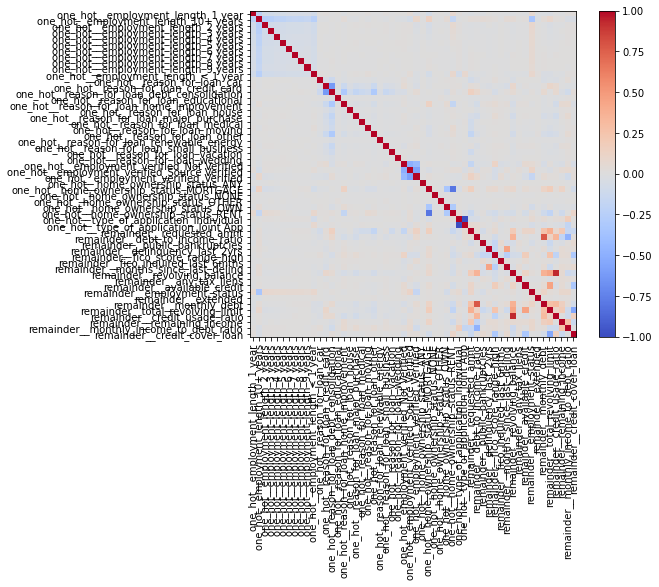

In [792]:
# Create DataFrame for X_train_encoded
X_train_df = pd.DataFrame(X_train_encoded, columns=column_names)
X_test_df = pd.DataFrame(X_test_encoded, columns=column_names)

corr_matrix = X_train_df.corr()

# visualize correlation matrix as a heatmap
fig = plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()


In [793]:
print(corr_matrix)

                                              one_hot__employment_length_1 year  \
one_hot__employment_length_1 year                                      1.000000   
one_hot__employment_length_10+ years                                  -0.211425   
one_hot__employment_length_2 years                                    -0.083733   
one_hot__employment_length_3 years                                    -0.078289   
one_hot__employment_length_4 years                                    -0.066797   
one_hot__employment_length_5 years                                    -0.068392   
one_hot__employment_length_6 years                                    -0.058682   
one_hot__employment_length_7 years                                    -0.056889   
one_hot__employment_length_8 years                                    -0.057508   
one_hot__employment_length_9 years                                    -0.052584   
one_hot__employment_length_< 1 year                                   -0.078792   
one_

In [794]:
for var1 in corr_matrix.columns:
    for var2 in corr_matrix.columns:
        if (corr_matrix.loc[var1,var2] > 0.8) and (corr_matrix.loc[var1,var2] < 1.0) and (var1 != var2):
            print(f"{var1} and {var2} have a correlation score of {corr_matrix.loc[var1,var2]}")

remainder__revolving_balance and remainder__credit_usage_ratio have a correlation score of 0.9347321206755356
remainder__credit_usage_ratio and remainder__revolving_balance have a correlation score of 0.9347321206755356


In [795]:
for var1 in corr_matrix.columns:
    for var2 in corr_matrix.columns:
        if (corr_matrix.loc[var1,var2] > -1) and (corr_matrix.loc[var1,var2] < -0.8) and (var1 != var2):
            print(f"{var1} and {var2} have a correlation score of {corr_matrix.loc[var1,var2]}")

one_hot__home_ownership_status_MORTGAGE and one_hot__home_ownership_status_RENT have a correlation score of -0.8018516566236812
one_hot__home_ownership_status_RENT and one_hot__home_ownership_status_MORTGAGE have a correlation score of -0.8018516566236812
one_hot__type_of_application_Individual and one_hot__type_of_application_Joint App have a correlation score of -0.9999999999999983
one_hot__type_of_application_Joint App and one_hot__type_of_application_Individual have a correlation score of -0.9999999999999983


In [796]:
X_train_df_v2  = X_train_df.drop(["remainder__revolving_balance", 'one_hot__home_ownership_status_RENT', 'one_hot__type_of_application_Joint App'],  axis=1).copy()
X_test_df_v2  = X_test_df.drop(["remainder__revolving_balance", 'one_hot__home_ownership_status_RENT', 'one_hot__type_of_application_Joint App'],  axis=1).copy()

In [797]:
scaler = RobustScaler()
X_train_scaled_v2 = scaler.fit_transform(X_train_df_v2.values)
X_test_scaled_v2 = scaler.fit_transform(X_test_df_v2.values)

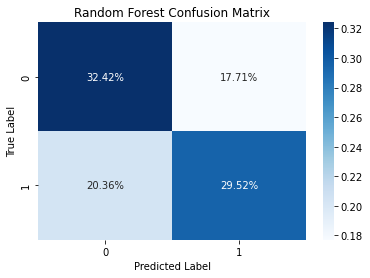

In [799]:
#class_weights = {0: 1, 1: 2}  # Assign higher weight to class 0 (minority class)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled_v2, y_train)

lr_pred = lr_model.predict(X_test_scaled_v2)

cf_matrix = confusion_matrix(y_test, lr_pred)

# Visualize confusion matrix using heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [800]:
# Calculate precision, recall, and F1-score
classification_metrics = classification_report(y_test, lr_pred)

# Print the metrics

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.61      0.65      0.63     40124
           1       0.63      0.59      0.61     39928

    accuracy                           0.62     80052
   macro avg       0.62      0.62      0.62     80052
weighted avg       0.62      0.62      0.62     80052



In [787]:
cleaned_test_encoded_df = pd.DataFrame(cleaned_test_encoded, columns=column_names)
cleaned_test_encoded_df_v2  = cleaned_test_encoded_df.drop(["remainder__revolving_balance", 'one_hot__home_ownership_status_RENT', 'one_hot__type_of_application_Joint App'],  axis=1).copy()

cleaned_test_scaled_v2 = scaler.transform(cleaned_test_encoded_df_v2)

In [789]:
lr_prediction = lr_model.predict(cleaned_test_scaled_v2)

submission = pd.DataFrame({ 'ID': final_id,
                            'loan_paid': lr_prediction })


print(submission.dtypes)

ID           int64
loan_paid    int64
dtype: object


In [790]:
submission.to_csv(".../prediction_lr_df.csv", index=False)